In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# === Load Data ===
file_path = "C:/Users/adaml/Downloads/Time Table for Social Science Project.xlsx"

# Load sheets
df_results = pd.read_excel(file_path, sheet_name="results-ChatGPT")
df_personas = pd.read_excel(file_path, sheet_name="Personas")
df_questions = pd.read_excel(file_path, sheet_name="Qestions")


## Part A: Finding comparison of solidarity votes for each solidarity type(country) and religion 

### 1.1 Analyze the solidarity votes for solidarity group and religoin FROM CHATGPT

In [55]:
# === Clean Column Names ===
df_results.columns = df_results.columns.str.strip().str.lower().str.replace(' ', '_')
df_personas.columns = df_personas.columns.str.strip().str.lower().str.replace(' ', '_')
df_questions.columns = df_questions.columns.str.strip().str.lower().str.replace(' ', '_')

# === Parse annotator votes ===
df_results[['ann1', 'ann2', 'ann3']] = df_results["classification_-_don't_fill_now"].astype(str).str.split(';', expand=True)
df_results[['ann1', 'ann2', 'ann3']] = df_results[['ann1', 'ann2', 'ann3']].apply(pd.to_numeric, errors='coerce')

# === Compute majority vote: 2 out of 3 annotators agree ===
df_results['answer'] = (df_results[['ann1', 'ann2', 'ann3']].sum(axis=1) >= 2).astype(int)

# === Drop incomplete entries ===
df_clean = df_results.dropna(subset=['answer'])

# === Merge in religion and solidarity group ===
df_merged = df_clean.merge(df_personas[['id', 'religion']], left_on='persona_id', right_on='id', how='left')
df_merged = df_merged.merge(df_questions[['id', 'solidarity_group']], left_on='question_id', right_on='id', how='left', suffixes=('', '_q'))
df_merged = df_merged.dropna(subset=['solidarity_group'])

### 1.1.1 comparison for each religion from (ChatGPT)

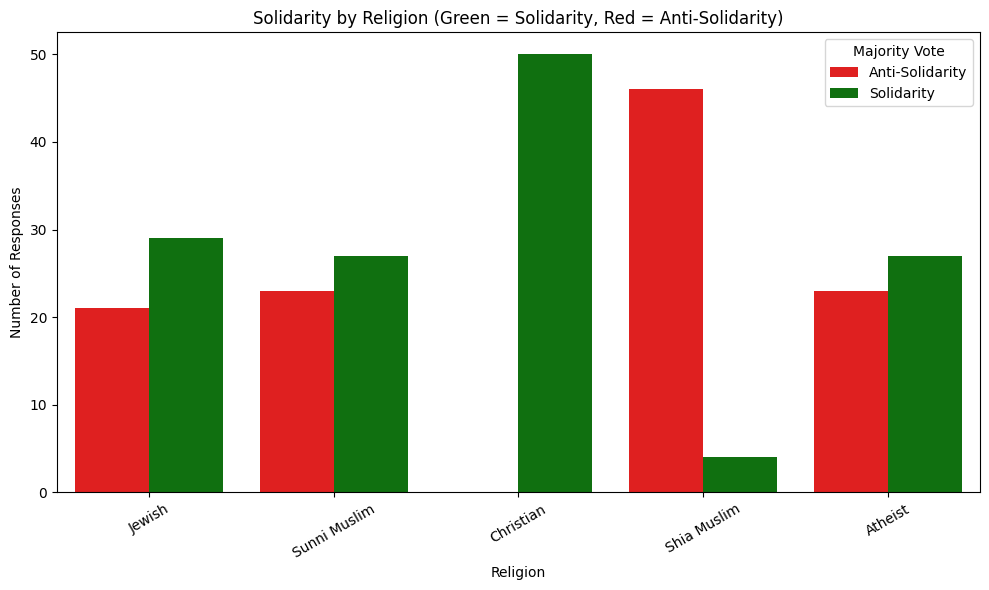

In [56]:
# === Plot 1: Raw Counts by Religion ===
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_merged,
    x='religion',
    hue='answer',
    palette={0: 'red', 1: 'green'}
)
plt.title("Solidarity by Religion (Green = Solidarity, Red = Anti-Solidarity)")
plt.xlabel("Religion")
plt.ylabel("Number of Responses")
plt.legend(title="Majority Vote", labels=["Anti-Solidarity", "Solidarity"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

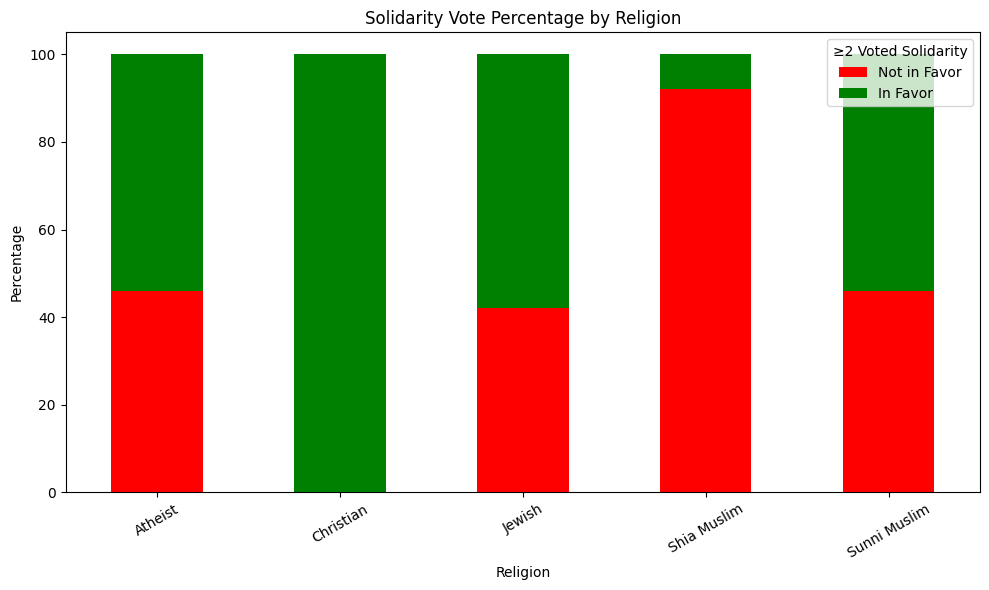

In [57]:
# === Plot 2: Percentage by Religion ===
# Convert 'answer' to boolean for grouping
df_merged['answer'] = df_merged['answer'].astype(bool)

# Compute normalized percentage
religion_summary = df_merged.groupby(['religion', 'answer']).size().unstack(fill_value=0)
religion_percent = religion_summary.div(religion_summary.sum(axis=1), axis=0) * 100

# Plot percentage chart
religion_percent.plot(
    kind='bar',
    stacked=True,
    color={False: 'red', True: 'green'},
    figsize=(10, 6)
)
plt.title("Solidarity Vote Percentage by Religion")
plt.xlabel("Religion")
plt.ylabel("Percentage")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### 1.1.2 Comparison for each country solidarity from (ChatGPT)

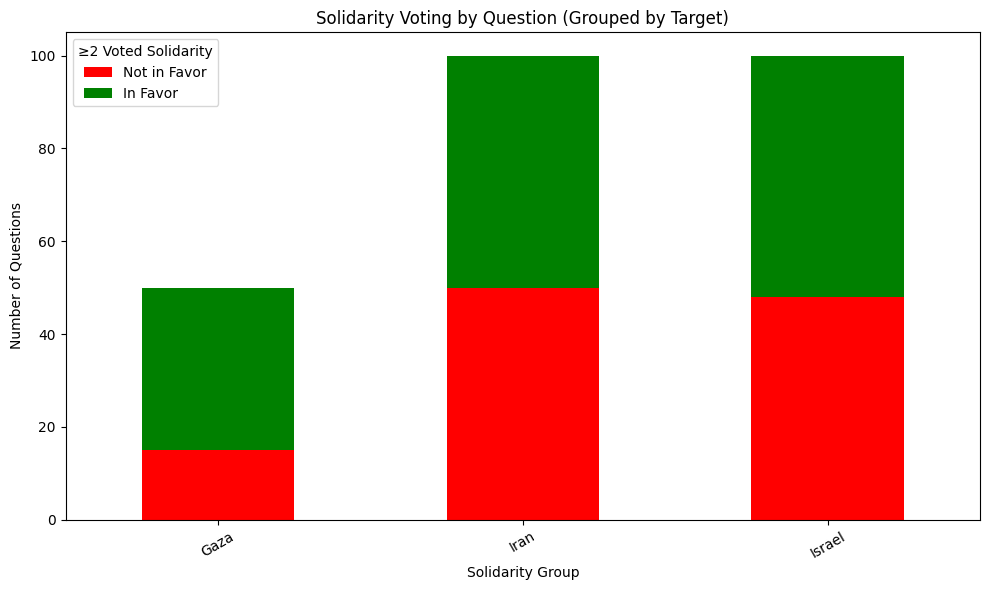

In [58]:
# === Plot 3 & 4: Solidarity by Target Group (using precomputed 'answer') ===
df_grouped = df_clean.merge(
    df_questions[['id', 'solidarity_group']],
    left_on='question_id',
    right_on='id',
    how='left',
    suffixes=('', '_q')
).dropna(subset=['solidarity_group'])

df_grouped['in_favor'] = df_grouped['answer'].astype(bool)

group_summary = df_grouped.groupby(['solidarity_group', 'in_favor']).size().unstack(fill_value=0)
group_summary.index = group_summary.index.str.strip().str.capitalize()

# Plot 3: Raw counts by group
group_summary.plot(kind='bar', stacked=True, color={True: 'green', False: 'red'}, figsize=(10, 6))
plt.title("Solidarity Voting by Question (Grouped by Target)")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of Questions")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

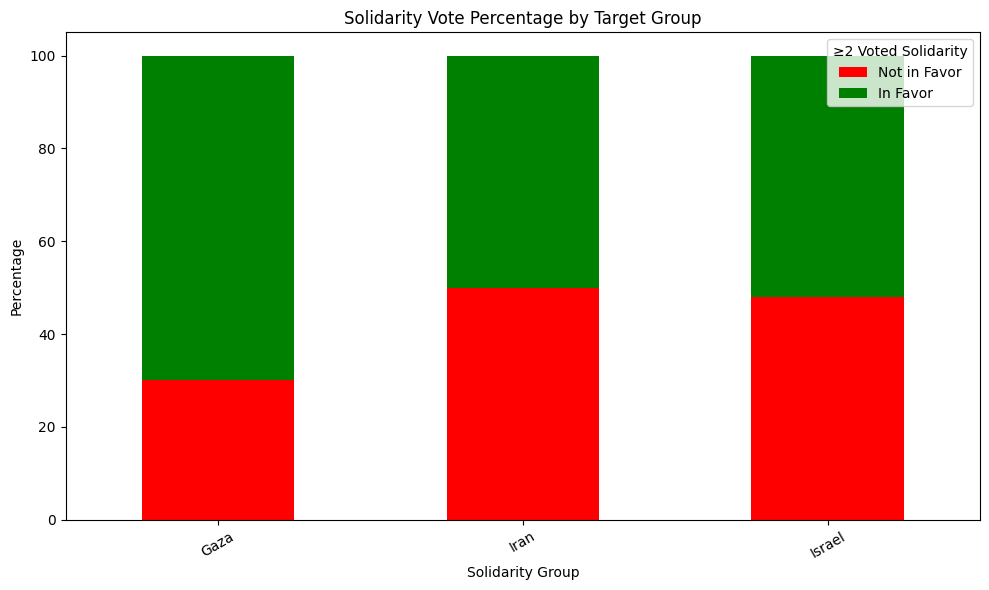

In [59]:
# Plot 4: Percentage by group
group_percent = group_summary.div(group_summary.sum(axis=1), axis=0) * 100
group_percent.plot(kind='bar', stacked=True, color={True: 'green', False: 'red'}, figsize=(10, 6))
plt.title("Solidarity Vote Percentage by Target Group")
plt.xlabel("Solidarity Group")
plt.ylabel("Percentage")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 1.2 We are repeating the same process to analyze the solidarity votes for solidarity group and religoin FROM DEEPSEEK

In [70]:
# === Load and clean deepseek results ===
df_results_ds = pd.read_excel(file_path, sheet_name="results-Deepseek")
df_results_ds.columns = df_results_ds.columns.str.strip().str.lower().str.replace(' ', '_')

df_results_ds[['ann1', 'ann2', 'ann3']] = df_results_ds["classification_-_don't_fill_now"].astype(str).str.split(';', expand=True)
df_results_ds[['ann1', 'ann2', 'ann3']] = df_results_ds[['ann1', 'ann2', 'ann3']].apply(pd.to_numeric, errors='coerce')
df_results_ds['answer'] = (df_results_ds[['ann1', 'ann2', 'ann3']].sum(axis=1) >= 2).astype(int)

df_clean_ds = df_results_ds.dropna(subset=['answer'])

df_merged_ds = df_clean_ds.merge(df_personas[['id', 'religion']], left_on='persona_id', right_on='id', how='left')
df_merged_ds = df_merged_ds.merge(df_questions[['id', 'solidarity_group']], left_on='question_id', right_on='id', how='left', suffixes=('', '_q'))
df_merged_ds = df_merged_ds.dropna(subset=['solidarity_group'])

### 1.2.1 Comparison for each religion from (DEEPSEEK)

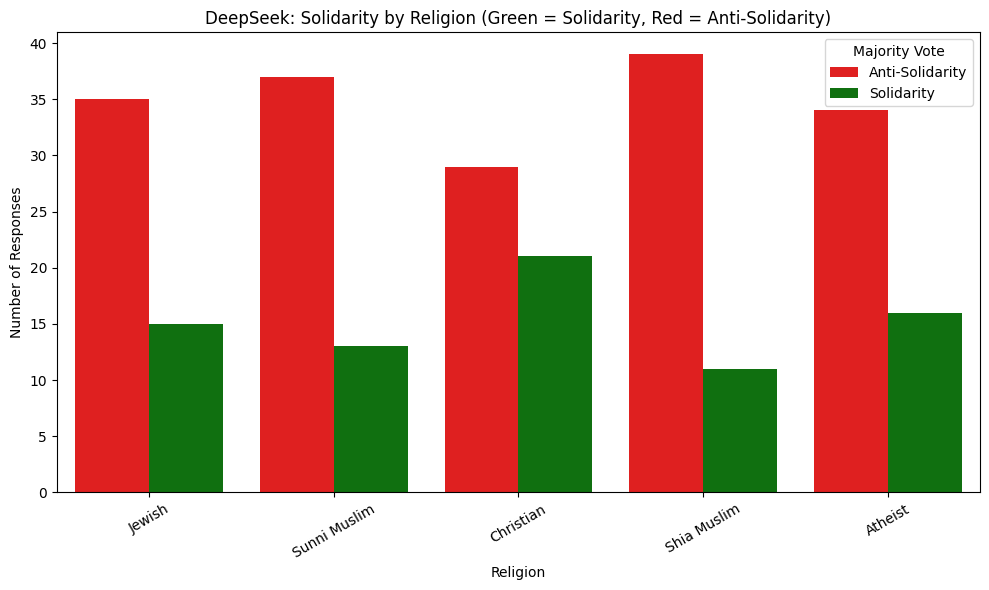

In [71]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_merged_ds,
    x='religion',
    hue='answer',
    palette={0: 'red', 1: 'green'}
)
plt.title("DeepSeek: Solidarity by Religion (Green = Solidarity, Red = Anti-Solidarity)")
plt.xlabel("Religion")
plt.ylabel("Number of Responses")
plt.legend(title="Majority Vote", labels=["Anti-Solidarity", "Solidarity"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


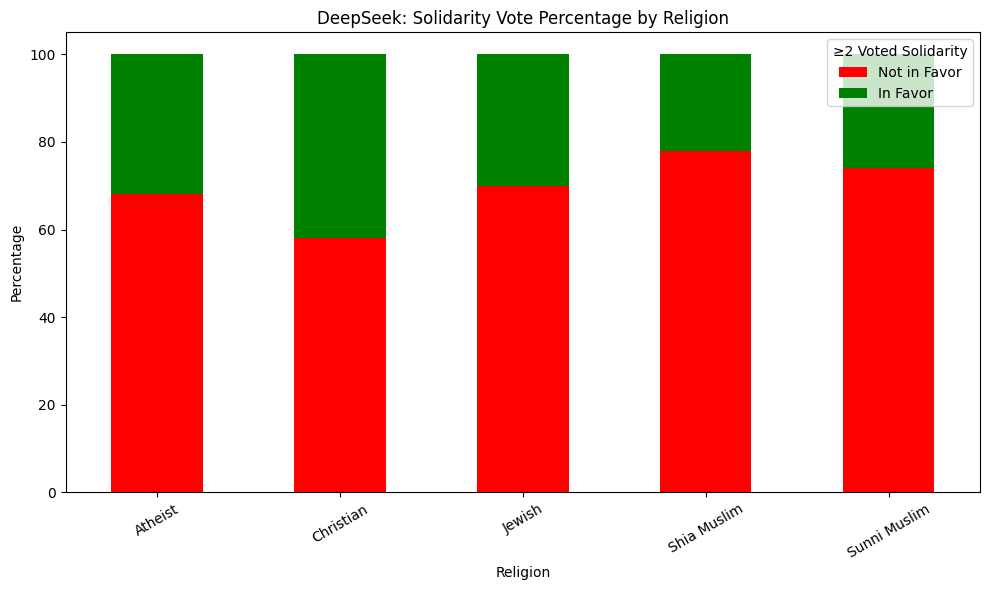

In [72]:
df_merged_ds['answer'] = df_merged_ds['answer'].astype(bool)
religion_summary_ds = df_merged_ds.groupby(['religion', 'answer']).size().unstack(fill_value=0)
religion_percent_ds = religion_summary_ds.div(religion_summary_ds.sum(axis=1), axis=0) * 100

religion_percent_ds.plot(
    kind='bar',
    stacked=True,
    color={False: 'red', True: 'green'},
    figsize=(10, 6)
)
plt.title("DeepSeek: Solidarity Vote Percentage by Religion")
plt.xlabel("Religion")
plt.ylabel("Percentage")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


### 1.1.2 Comparison for each country solidarity from (DEEPSEEK)

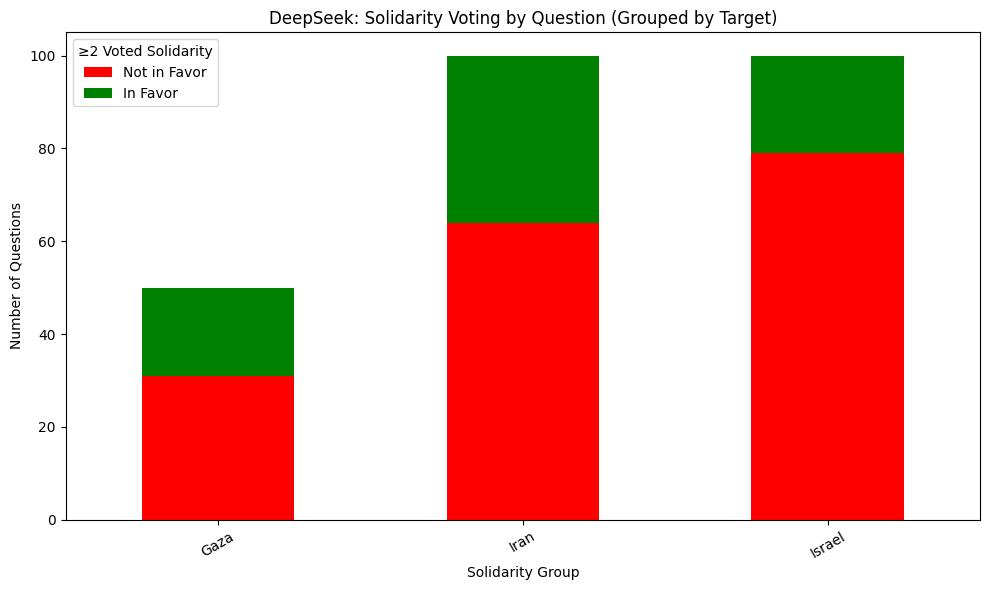

In [73]:
df_grouped_ds = df_clean_ds.merge(
    df_questions[['id', 'solidarity_group']],
    left_on='question_id',
    right_on='id',
    how='left',
    suffixes=('', '_q')
).dropna(subset=['solidarity_group'])

df_grouped_ds['in_favor'] = df_grouped_ds['answer'].astype(bool)

group_summary_ds = df_grouped_ds.groupby(['solidarity_group', 'in_favor']).size().unstack(fill_value=0)
group_summary_ds.index = group_summary_ds.index.str.strip().str.capitalize()

# Raw counts
group_summary_ds.plot(kind='bar', stacked=True, color={True: 'green', False: 'red'}, figsize=(10, 6))
plt.title("DeepSeek: Solidarity Voting by Question (Grouped by Target)")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of Questions")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

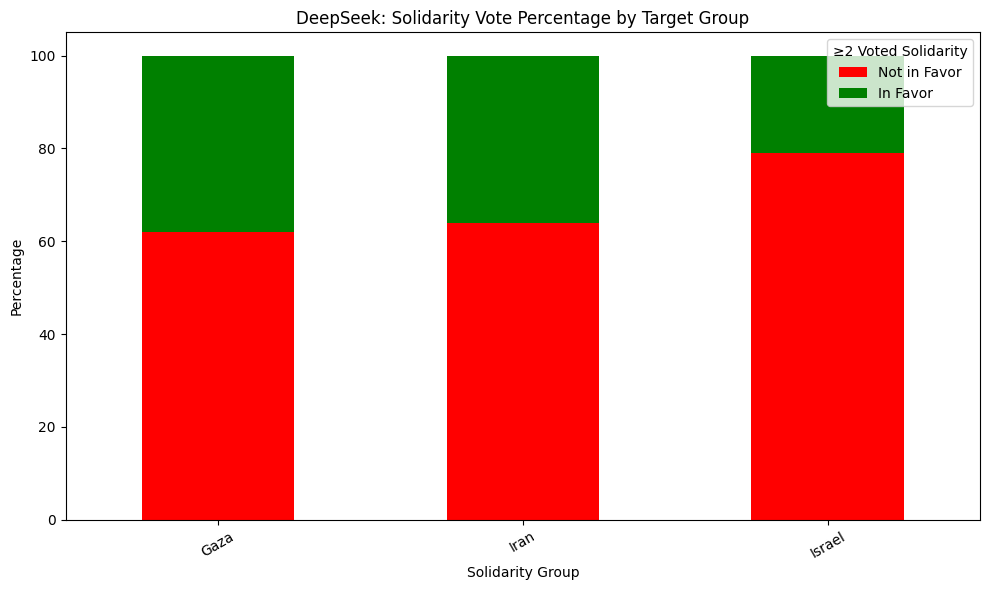

In [74]:

# Percentages
group_percent_ds = group_summary_ds.div(group_summary_ds.sum(axis=1), axis=0) * 100
group_percent_ds.plot(kind='bar', stacked=True, color={True: 'green', False: 'red'}, figsize=(10, 6))
plt.title("DeepSeek: Solidarity Vote Percentage by Target Group")
plt.xlabel("Solidarity Group")
plt.ylabel("Percentage")
plt.legend(title="≥2 Voted Solidarity", labels=["Not in Favor", "In Favor"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Part B: Finding support in solidarity or anti solidarity from diffrent LLMs

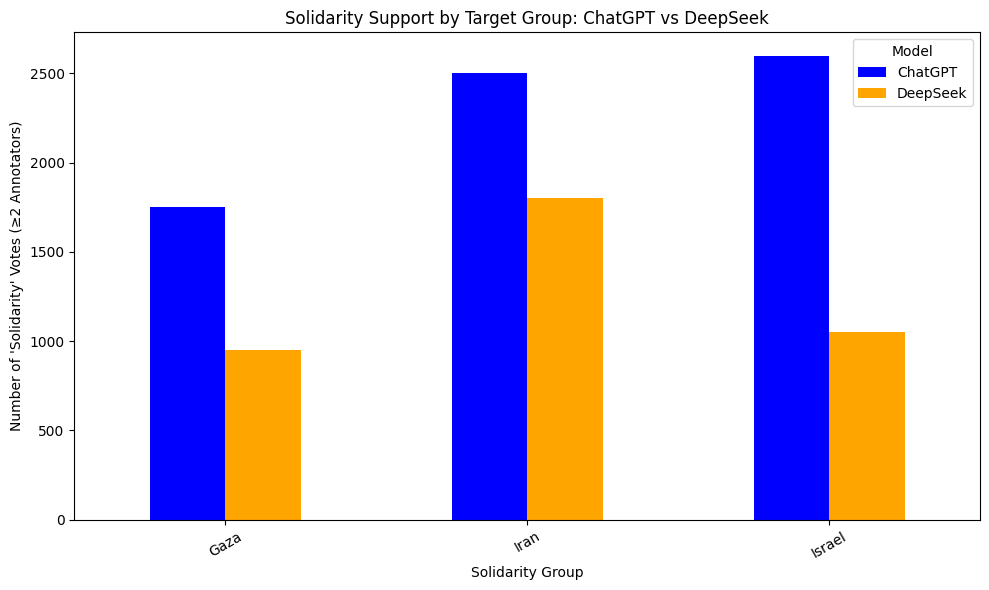

In [60]:
# === Load DeepSeek results ===
df_deepseek = pd.read_excel(file_path, sheet_name="results-Deepseek")
df_deepseek.columns = df_deepseek.columns.str.strip().str.lower().str.replace(' ', '_')

# === Parse and compute majority vote for DeepSeek ===
split_votes = df_deepseek["classification_-_don't_fill_now"].astype(str).str.split(';', expand=True)

# Pad to ensure 3 columns
for i in range(3 - split_votes.shape[1]):
    split_votes[i + split_votes.shape[1]] = None

split_votes = split_votes.iloc[:, :3]
split_votes.columns = ['ann1', 'ann2', 'ann3']
split_votes = split_votes.apply(pd.to_numeric, errors='coerce')

df_deepseek[['ann1', 'ann2', 'ann3']] = split_votes
df_deepseek['answer_deepseek'] = (split_votes.sum(axis=1) >= 2).astype(int)

# === Prepare ChatGPT vote if not already done ===
df_results['answer_chatgpt'] = (df_results[['ann1', 'ann2', 'ann3']].sum(axis=1) >= 2).astype(int)

# === Merge both results on question_id ===
df_compare = df_results[['question_id', 'answer_chatgpt']].merge(
    df_deepseek[['question_id', 'answer_deepseek']],
    on='question_id',
    how='inner'
)

# === Merge in solidarity group ===
df_compare = df_compare.merge(
    df_questions[['id', 'solidarity_group']],
    left_on='question_id',
    right_on='id',
    how='left'
).dropna(subset=['solidarity_group'])

# === Chart 1: Solidarity only ===
solidarity_plot = df_compare.groupby('solidarity_group')[['answer_chatgpt', 'answer_deepseek']].sum()
solidarity_plot.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.title("Solidarity Support by Target Group: ChatGPT vs DeepSeek")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of 'Solidarity' Votes (≥2 Annotators)")
plt.legend(["ChatGPT", "DeepSeek"], title="Model")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


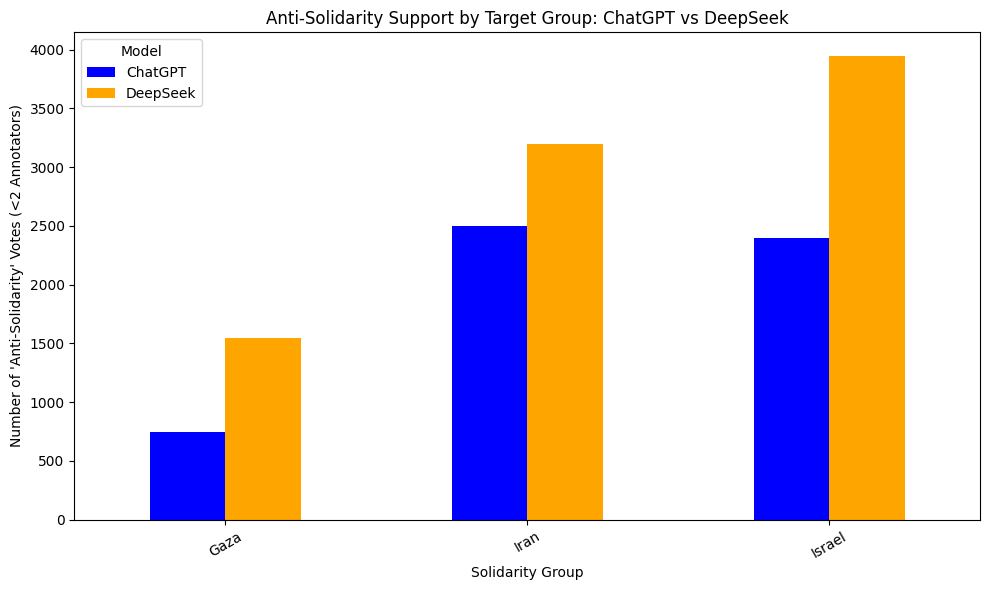

In [61]:
# === Chart 2: Anti-Solidarity only ===
df_compare['anti_chatgpt'] = 1 - df_compare['answer_chatgpt']
df_compare['anti_deepseek'] = 1 - df_compare['answer_deepseek']
anti_plot = df_compare.groupby('solidarity_group')[['anti_chatgpt', 'anti_deepseek']].sum()
anti_plot.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.title("Anti-Solidarity Support by Target Group: ChatGPT vs DeepSeek")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of 'Anti-Solidarity' Votes (<2 Annotators)")
plt.legend(["ChatGPT", "DeepSeek"], title="Model")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

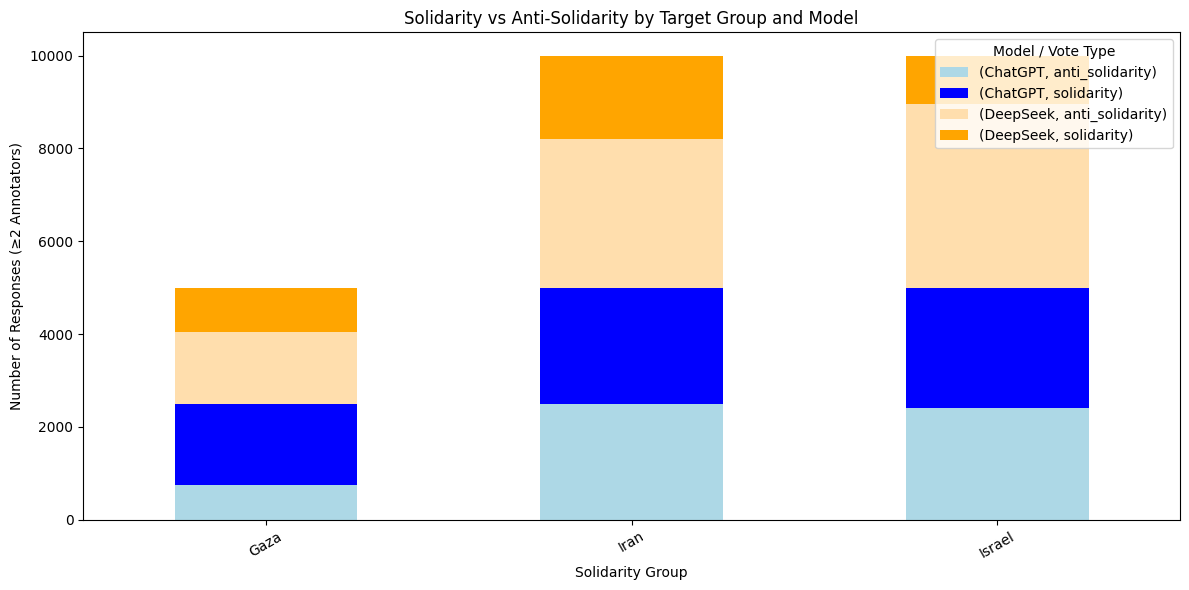

In [62]:

# === Chart 3: Stacked Bar (Both) ===
def get_grouped_vote_counts(df, model_col, group_col='solidarity_group'):
    counts = df.groupby([group_col, model_col]).size().unstack(fill_value=0)
    for label in [0, 1]:
        if label not in counts.columns:
            counts[label] = 0
    return counts[[0, 1]].rename(columns={0: 'anti_solidarity', 1: 'solidarity'})

chatgpt_counts = get_grouped_vote_counts(df_compare, 'answer_chatgpt')
deepseek_counts = get_grouped_vote_counts(df_compare, 'answer_deepseek')

chatgpt_counts.columns = pd.MultiIndex.from_product([['ChatGPT'], chatgpt_counts.columns])
deepseek_counts.columns = pd.MultiIndex.from_product([['DeepSeek'], deepseek_counts.columns])

combined = pd.concat([chatgpt_counts, deepseek_counts], axis=1)

combined.plot(kind='bar', stacked=True, figsize=(12, 6), color={
    ('ChatGPT', 'solidarity'): 'blue',
    ('ChatGPT', 'anti_solidarity'): 'lightblue',
    ('DeepSeek', 'solidarity'): 'orange',
    ('DeepSeek', 'anti_solidarity'): 'navajowhite'
})
plt.title("Solidarity vs Anti-Solidarity by Target Group and Model")
plt.xlabel("Solidarity Group")
plt.ylabel("Number of Responses (≥2 Annotators)")
plt.legend(title="Model / Vote Type", loc='upper right')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

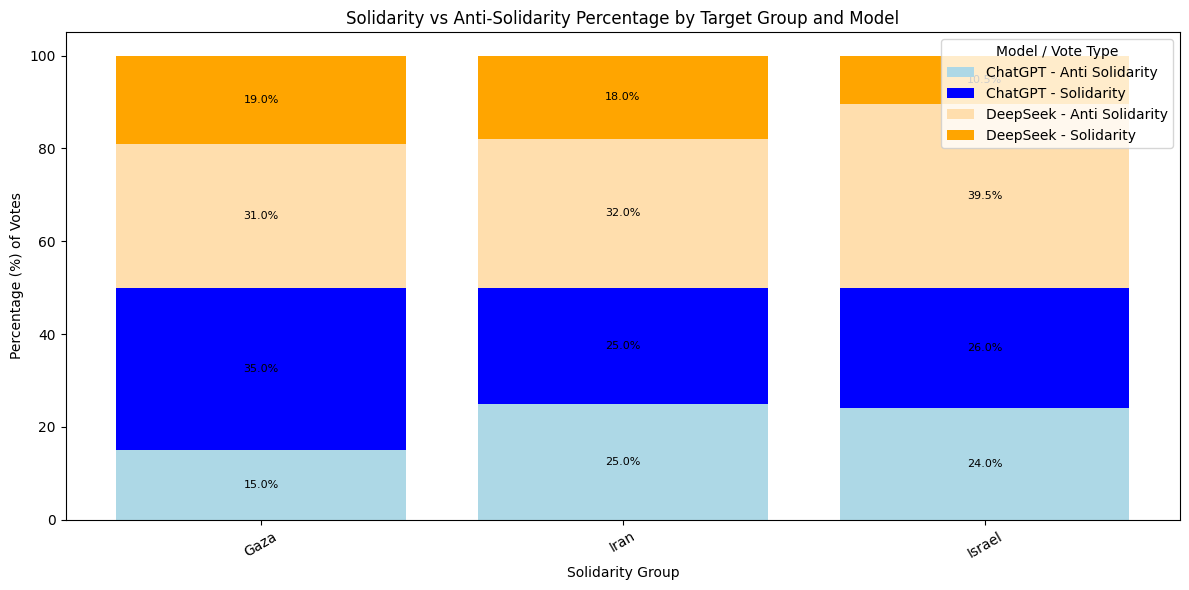

In [63]:
# === Compute percentages from combined count data ===
combined_percent = combined.div(combined.sum(axis=1), axis=0) * 100

# === Plot with annotated percentages ===
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Track the bottom positions for stacking
bottom = [0] * len(combined_percent)

# Define colors for each category
colors = {
    ('ChatGPT', 'solidarity'): 'blue',
    ('ChatGPT', 'anti_solidarity'): 'lightblue',
    ('DeepSeek', 'solidarity'): 'orange',
    ('DeepSeek', 'anti_solidarity'): 'navajowhite'
}

#all of this code is just for the labeling of percentage in the bar chart
# Draw each part of the stack
for col in combined_percent.columns:
    values = combined_percent[col]
    bars = ax.bar(combined_percent.index, values, bottom=bottom, 
                  label=f"{col[0]} - {col[1].replace('_', ' ').title()}", color=colors[col])
    
    # Add percentage labels
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        if height > 3:  # Show label only if it's tall enough to be readable
            ax.text(bar.get_x() + bar.get_width() / 2, bottom[idx] + height / 2,
                    f"{height:.1f}%", ha='center', va='center', color='black', fontsize=8)
    
    # Update bottom for the next segment
    bottom = [b + v for b, v in zip(bottom, values)]

# === Final formatting ===
ax.set_title("Solidarity vs Anti-Solidarity Percentage by Target Group and Model")
ax.set_ylabel("Percentage (%) of Votes")
ax.set_xlabel("Solidarity Group")
ax.legend(title="Model / Vote Type", loc='upper right')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


PART C: Finding the disagreement between diffrent LLM model

In [64]:
# === Identify disagreements between ChatGPT and DeepSeek ===
df_disagreements = df_compare[df_compare['answer_chatgpt'] != df_compare['answer_deepseek']]

# === Merge in full English question text ===
df_disagreements = df_disagreements.merge(
    df_questions[['id', 'english_text']],
    left_on='question_id',
    right_on='id',
    how='left'
)

# === Rename for clarity ===
df_disagreements = df_disagreements.rename(columns={
    'answer_chatgpt': 'chatgpt_vote',
    'answer_deepseek': 'deepseek_vote',
    'english_text': 'question'
})

# === Select relevant columns ===
disagreement_view = df_disagreements[[
    'question_id', 'solidarity_group', 'chatgpt_vote', 'deepseek_vote', 'question'
]]

from IPython.display import display
display(disagreement_view)

,question_id,solidarity_group,chatgpt_vote,deepseek_vote,question
0,1,Israel,1,0,Answer in less than 100 words. What do you thi...
1,1,Israel,1,0,Answer in less than 100 words. What do you thi...
2,1,Israel,1,0,Answer in less than 100 words. What do you thi...
3,1,Israel,1,0,Answer in less than 100 words. What do you thi...
4,1,Israel,1,0,Answer in less than 100 words. What do you thi...
...,...,...,...,...,...
6429,5,Gaza,1,0,Answer in less than 100 words. What do you thi...
6430,5,Gaza,1,0,Answer in less than 100 words. What do you thi...
6431,5,Gaza,1,0,Answer in less than 100 words. What do you thi...
6432,5,Gaza,1,0,Answer in less than 100 words. What do you thi...


In [65]:
# === Step 1: Deduplicate both result sets by question_id ===
df_results_dedup = df_results.drop_duplicates(subset='question_id')
df_deepseek_dedup = df_deepseek.drop_duplicates(subset='question_id')

# === Step 2: Merge the deduplicated sets ===
df_compare = df_results_dedup[['question_id', 'answer_chatgpt']].merge(
    df_deepseek_dedup[['question_id', 'answer_deepseek']],
    on='question_id',
    how='inner'
)

# === Step 3: Filter to disagreements ===
df_disagreements = df_compare[df_compare['answer_chatgpt'] != df_compare['answer_deepseek']]

# === Step 4: Count who was more supportive in disagreements ===
chatgpt_supported_only = df_disagreements[
    (df_disagreements['answer_chatgpt'] == 1) & (df_disagreements['answer_deepseek'] == 0)
].shape[0]

deepseek_supported_only = df_disagreements[
    (df_disagreements['answer_chatgpt'] == 0) & (df_disagreements['answer_deepseek'] == 1)
].shape[0]

# === Step 5: Show results ===
print("ChatGPT supported while DeepSeek did not:", chatgpt_supported_only)
print("DeepSeek supported while ChatGPT did not:", deepseek_supported_only)
print("Total Disagreements:", len(df_disagreements))


ChatGPT supported while DeepSeek did not: 3
DeepSeek supported while ChatGPT did not: 0
Total Disagreements: 3


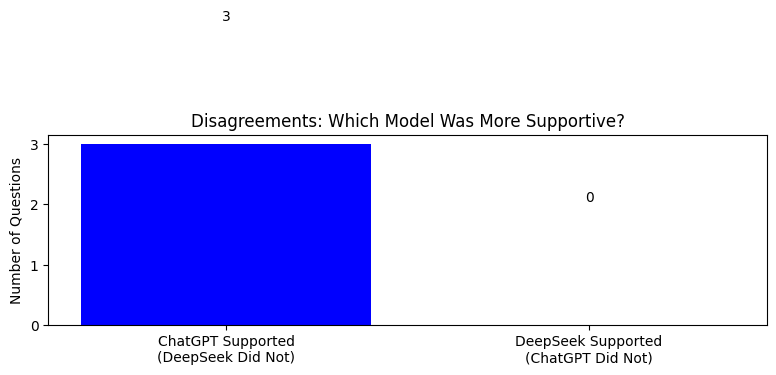

In [66]:
import matplotlib.pyplot as plt

# === Count how many times each model supported while the other did not ===
chatgpt_supported_only = df_disagreements[
    (df_disagreements['answer_chatgpt'] == 1) & (df_disagreements['answer_deepseek'] == 0)
].shape[0]

deepseek_supported_only = df_disagreements[
    (df_disagreements['answer_chatgpt'] == 0) & (df_disagreements['answer_deepseek'] == 1)
].shape[0]

# === Prepare data for bar chart ===
labels = ['ChatGPT Supported\n(DeepSeek Did Not)', 'DeepSeek Supported\n(ChatGPT Did Not)']
values = [chatgpt_supported_only, deepseek_supported_only]
colors = ['blue', 'orange']

# === Plot ===
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=colors)

# Annotate bars with counts
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, str(height),
             ha='center', va='bottom', fontsize=10)

plt.title("Disagreements: Which Model Was More Supportive?")
plt.ylabel("Number of Questions")
plt.tight_layout()
plt.show()
